In [1]:
import glob
import gdal
import osr
import os
import datetime as dt
import numpy as np
from PIL import Image
from IPython.display import SVG, display
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'

In [2]:
# specifiy the bands we are interested in using
# in the tutorial
# https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/resolutions/spatial
bands = ['B2', 'B3', 'B4', 'B8']

# specifiy where the data is stored
file_root = '/data/un_suriname_demo/datacube/S2_SR/'

# specifiy which year you would like to examine 
year = '2019'

## Section 1 - GDAL
Gdal is an essential toolbox when handling EO data. It is responsible for opening datasets, handling their projections and is capable of manipulating the data to fit whatever configuration is needed. Like allot of geospatial libraries, it is not particularly easy to use and can be a bit tricky. <br> <br>

The first step to using gdal is opening a 'Dataset'. This is the top level entry point into the data, where you can access the raster bands and all the metadata. The actual data from the satellite is stored in these raster bands, where the way the raster bands relate to the earths surface is stored in the metadata. <br><br>

A great tutorial and cookbook on gdal and common operations can be found here:<br>
https://pcjericks.github.io/py-gdalogr-cookbook/raster_layers.html<br>
Another fantastic tutorial on using gdal is here:<br>
https://github.com/jgomezdans/geogg122-1/blob/master/Chapter4_GDAL/GDAL_Python_bindings.ipynb

In [3]:
test_file = '/data/un_suriname_demo/datacube/S2_SR/B2/aoi/S2_SR_B2_aoi_2019-09.tif'
# to open a gdal Dataset, call the library and the method '.Open' which will open
# the dataset.
opn = gdal.Open(test_file)
# when you print the variable 'opn', you can see it is a 'gdal.Dataset' type.
print (opn)

# if the variable 'opn' returns None, then gdal could not open the dataset
if opn is None:
    raise ValueError('gdal could not open the dataset!')

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f59f474e6c0> >


In [4]:
# there are lots of useful commands that can be used here
# to look at the dataset. The first is the size of the image

print ('Number of pixels on the x axis:')
print (opn.RasterXSize)
print ('Number of pixels on the y axis:')
print (opn.RasterYSize)

# you can also look at the number of layers within the dataset
print ('Number of layers:')
print (opn.RasterCount)

Number of pixels on the x axis:
512
Number of pixels on the y axis:
379
Number of layers:
6


EO data is generally stored with the following dimensions:<br>
time (axis 0)<br>
latitude or Y dimension (axis 1) <br>
longitude or X dimension (axis 2)<br>

In [5]:
# therefore the dimensions of the dataset are:
[opn.RasterCount, opn.RasterYSize, opn.RasterXSize]

[6, 379, 512]

To access the data, you can either access all the data at once or you can access each layer individualy.

In [6]:
# to access the first layer without opening all the data, use the 
# 'GetRasterBand' method with 1 as the argument. This opens the 
# first rasterband as 'gdal.Band'. Gdal counts from 1, so access
# layer 1, use '.GetRasterBand(1)'.
rst = opn.GetRasterBand(1)
# you can read the EO data by using the method 'ReadAsArray()'
# which will opent the forst rasterband as a 2D numpy array
arr = rst.ReadAsArray()
print ('2D Raster Size')
print (arr.shape)

2D Raster Size
(379, 512)


3D Raster Size
(6, 379, 512)


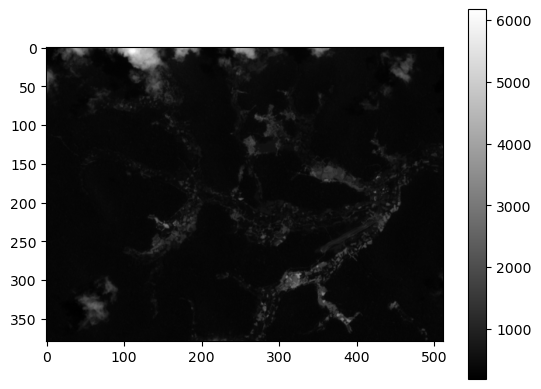

In [7]:
# to open everything at once, use the method 'ReadAsArray' directly
# on the Dataset, which will open all the data into a 3D numpy array
arr = opn.ReadAsArray()
print ('3D Raster Size')
print (arr.shape)

# you can examine the first layer by indexing the first element of
# the array
first_layer = arr[0]
# we can display the image with the matplotlib '.imshow' function
# as we have opened the 'B2' file, this contains the blue reflectance
# values. 
plt.imshow(first_layer)
# and show a colorbar
plt.colorbar()

# CC: Describe that this is dynamic range problem

In the above image, matplotlib will automatically set the limits of the pixel values. In the image, there are some very high values from clouded regions, which makes the contrast of the image very low.

If we want to see more details in the surface, we can set the 'vmin' and 'vmax' values, so that the colorscale covers the range we are interested and adds visible contrast in the image.

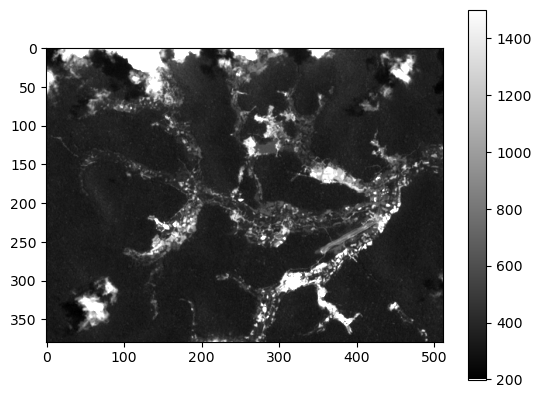

In [9]:
vmin = 200
vmax = 1500
plt.imshow(first_layer,vmin=vmin, vmax=vmax) 
plt.colorbar()

Notice that the values in the image range from ~400 to ~6000. In the previous lecture we talked about using reflectance values from Sentinel 2, where the reflectance values ranged from 0 to 1. The raw Sentinel 2 values are actualy refletcance values like this, but have been scaled for data compression reasons. To represent Sentinel 2 data on a 0 to 1 scale, simply divide the data by 10000 (scaled_data = first_layer / 10000)

In [19]:
# using gdal, we can also view the projection information. This is 
# the allignment of the 2D data onto a 3D world. 
current_projection_information = opn.GetProjectionRef()
print ('Current Projection:\n',current_projection_information)

# information on this projection can be found here:
# https://www.spatialreference.org/ref/epsg/wgs-84-utm-zone-21n/

Current Projection:
 PROJCS["WGS 84 / UTM zone 21N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-57],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32621"]]


To reproject data using gdal, we use 'gdal.Warp', which is very powerfull when handling geographic projection systems. To reproject an image we need to firstly establish the system we want to project into. For this example we will project into the 
commonly used latitude/longitude syetm in WGS84.

In [10]:
# setup an empty coordinate reference system object 
target_system = osr.SpatialReference()
# there are lots of ways to import a coordinate reference system
# where the simplest is to use the EPSG code, which is unique to each
# reference system. Here is a list of all EPSG codes:
# https://spatialreference.org/

# the system we are interested in is EPSG:4326
database_entry_for_projection = 4326
target_system.ImportFromEPSG(database_entry_for_projection)

# now we use gdal.Warp to create an in-memory reprojected dataset
# for a full list of all the option for this command, please
# use the official documentation:
# https://gdal.org/programs/gdalwarp.html

opn_reprojected = gdal.Warp('', test_file, format='MEM', dstSRS=target_system) # Empty first parameter string means no filename
                                                                               # because the object is in memory
# open up the data 
arr_reprojected = opn_reprojected.ReadAsArray()

# to export this data to disk, use the following syntax
_ = gdal.Warp('reprojected_output.tif', test_file, format='GTiff', dstSRS=target_system)

[None, None]

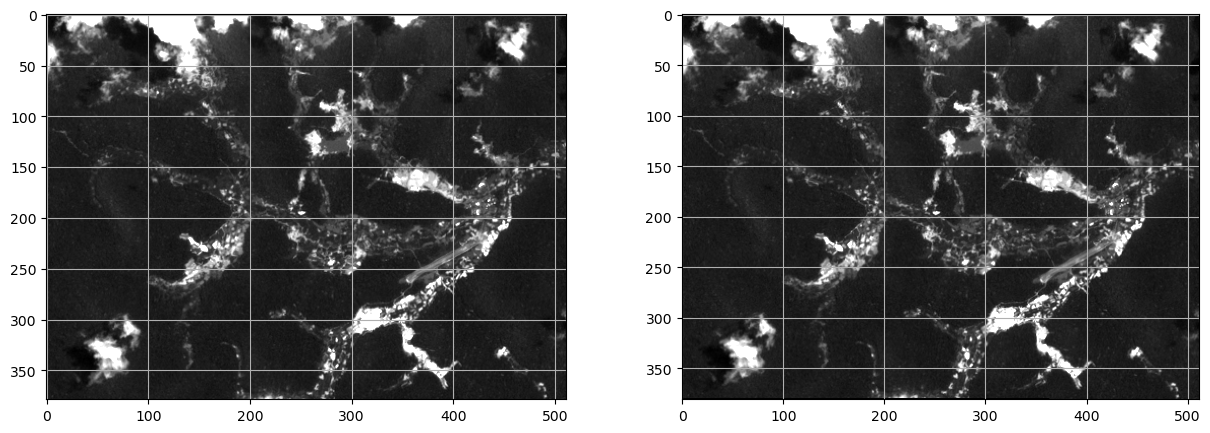

In [12]:
# you might to be able to spot very slight differences between the
# original and reprojected data, but visually they will look 
# pretty similar
fig,axs = plt.subplots(1,2,figsize=(15,5))
axs[0].imshow(arr[0],vmin=vmin,vmax=vmax)
axs[1].imshow(arr_reprojected[0],vmin=vmin,vmax=vmax)
[i.grid() for i in axs]

In [13]:
# the main differences are when you look at the pixel values themselves

print ('First Pixel Value in Original Dataset: ',arr[0,0,0])
print ('First Pixel Value in Preprojected Dataset: ',arr_reprojected[0,0,0])
print (' ')
print ('[10,10] Pixel Value in Original Dataset: ',arr[0,10,10])
print ('[10,10] Pixel Value in Preprojected Dataset: ',arr_reprojected[0,10,10])

# These differences are only small, but it is worth noting that when 
# data is reprojected from one coordinate system to another, the
# pixel values are resampled and changed. This means some detail
# can be lost along the way, so it is always good to work with the 
# original projection.

First Pixel Value in Original Dataset:  295.0
First Pixel Value in Preprojected Dataset:  0.0
 
[10,10] Pixel Value in Original Dataset:  585.0
[10,10] Pixel Value in Preprojected Dataset:  520.0


In [14]:
# for a great video on projection information, please view the following:
# https://www.youtube.com/watch?v=NAzy4S4EOwc&ab_channel=GeneralKnowledge

#### Test Your Understanding
Use 'GetRasterBand' to open the 3rd layer and use 'plt.imshow' to display it with appropriate vmin and vmax values

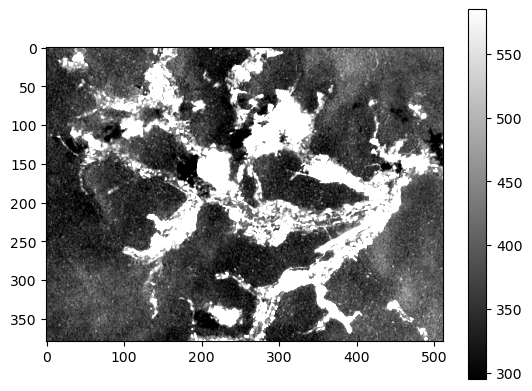

In [16]:
# test your understanding:


In [13]:
# test your understanding kernel:


# Section 2 - Indexing
Indexing is the process of selecting data from an array or for changing values in the array. For a full tutorial on the syntax and further details, please see this documentation:<br>
https://numpy.org/devdocs/user/basics.indexing.html

First Pixel value at [0,0]:  295.0


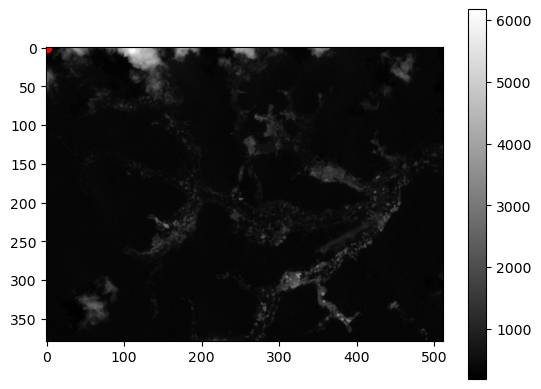

In [10]:
# notice that python indexes arrays from the top left
# lets quickly display where pixel value 0,0 is on the array
# in the top left. This is the bright red dot in the top left.
plt.imshow(first_layer)
plt.colorbar()
plt.scatter(0,0,c='r')
print ('First Pixel value at [0,0]: ',first_layer[0,0])

To index one pixel down from the first pixel use the following syntax, which puts a 1 in the column index position:

In [26]:
print ('Second Value Down: ',first_layer[1,0])

Second Value Down:  283.0


To index one pixel to the right of the first pixel use the following syntax, which puts a 1 in the row index position

In [16]:
print ('Second Value Right: ',first_layer[0,1])

Second Value Right:  287.0


To index the 5 row down and 7th column along, use the following:

In [17]:
first_layer[5,7]

258.0

If you want to access more than 1 value, we use a colon ':' we can show the first column, by using the colon symbol in the column index position

In [18]:
print ('First Column')
print (first_layer[:,0])
print (' ')
# we can also only show the first 5 values in the first row
# by using the colon and an index. This essentially mean:
# 'return all values up to the 5th value'.
print ('First 5 values of first column')
print (first_layer[:5,0])

First Column
[ 295.  283.  281.  288.  266.  287.  269.  254.  269.  271.  278.  271.
  263.  274.  252.  257.  282.  288.  275.  306.  323.  373.  526.  734.
  783.  778.  833.  872.  923. 1044. 1162. 1440. 1736. 2134. 2110. 2126.
 2244. 2306. 2328. 2286. 2310. 2336. 2282. 2170. 2070. 1910. 1730. 1634.
 1638. 1656. 1458. 1500. 1510. 1384. 1356. 1330. 1306. 1238. 1062.  837.
  623.  485.  455.  440.  405.  393.  419.  419.  381.  365.  375.  389.
  366.  376.  379.  379.  349.  357.  367.  341.  384.  387.  351.  388.
  377.  371.  379.  369.  357.  363.  358.  372.  368.  386.  380.  351.
  354.  373.  365.  360.  341.  381.  390.  384.  362.  357.  363.  358.
  345.  345.  346.  343.  343.  337.  315.  310.  346.  361.  364.  409.
  448.  437.  388.  330.  333.  328.  338.  369.  366.  348.  305.  307.
  346.  353.  345.  341.  338.  349.  354.  348.  353.  371.  337.  331.
  343.  341.  325.  343.  362.  351.  350.  356.  367.  353.  338.  353.
  359.  330.  338.  332.  339.  327.  

Lets plot the pixel values in the first columns. These are all the values along the left of the image

Text(0.5, 0, 'Position in column')

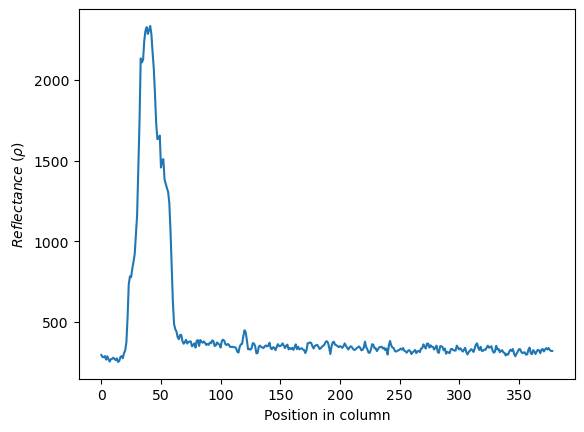

In [19]:
plt.plot(first_layer[:,0])
plt.ylabel(r"$Reflectance\ (\rho)$")
plt.xlabel('Position in column')

Text(0.5, 0, 'Position in row')

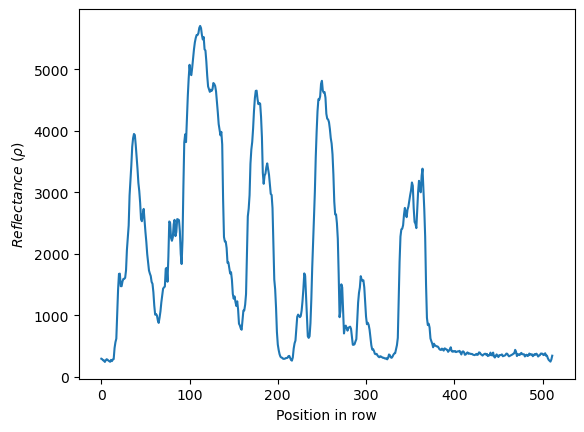

In [33]:
# and also plot the values in the first row
plt.plot(first_layer[0,:])
plt.ylabel(r"$Reflectance\ (\rho)$")
plt.xlabel('Position in row')

# these multiple spikes in reflectance correspond with cloud along the 
# the top row of the image

In python, when indexing data you can either can index from the start of the axis, like we were just doing, or from the last values with the '-' symbol

In [34]:
print ('The first 5 values in the first column:')
print (first_layer[:5,0])
print ('')
print ('The last 5 values in the first column:')
print (first_layer[-5:,0])

The first 5 values in the first column:
[295. 283. 281. 288. 266.]

The last 5 values in the first column:
[329. 338. 326. 320. 320.]


As well as selecting data, we also use indexing to set values in the array

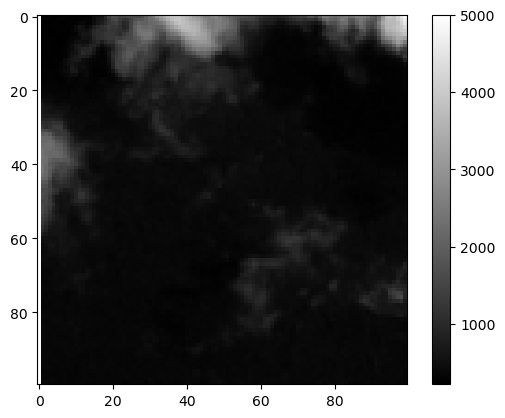

In [20]:
# make a quick copy of the image
copy_first_layer = np.copy(first_layer)
# we will also index the first 100 columns and rows
copy_first_layer = copy_first_layer[:100,:100]

# to set data, index the data we want and set values with '=' 
# in this example we will set the values of the first column 
# to a very high value so we can see them in the plot
copy_first_layer[:,0] = 5000

plt.imshow(copy_first_layer)
plt.colorbar()

# notice all the high white values on the left of the image
# which are these new set values 

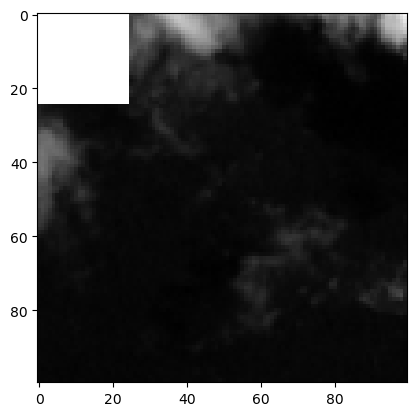

In [21]:
# make another quick copy 
copy_first_layer = np.copy(first_layer)
copy_first_layer = copy_first_layer[:100,:100]

# lets set a chunk of values to a high value
copy_first_layer[:25,:25] = 5000
plt.imshow(copy_first_layer)

# now see how we have set the first 25 values in Y and X 
# which is displayed with the bright white pixels

#### Test Your Understanding:
Make another new 'copy_test_layer' and set the last 10 values in Y and X to a value of 0

In [22]:
# test your understanding kernel:


# Section 3 - Creating a Layer Stack
Currently we have 1 month of data opened, but we want data on the whole year. This means we have to open multiple files and join then together in a '3D layer stack' for further processing. This is the monthly Band 2 files opened and joined up to create 1 continuous dataset. <br><br> For a detailed tutorial on different mays of manipulating multidimensional datasets, refer to this cookbook:<br>
https://python-course.eu/numerical-programming/numpy-arrays-concatenating-flattening-and-adding-dimensions.php

In [23]:
# to start, we are going to open both the January and Febuary files
opn_month_1 = gdal.Open('/data/un_suriname_demo/datacube/S2_SR/B2/aoi/S2_SR_B2_aoi_2019-01.tif')
opn_month_2 = gdal.Open('/data/un_suriname_demo/datacube/S2_SR/B2/aoi/S2_SR_B2_aoi_2019-02.tif')

print ('January has %s layers'%opn_month_1.RasterCount)
print ('Febuary has %s layers'%opn_month_2.RasterCount)

# Note that both January and Febuary have the same Y and X dimensions, as this will always
# be the same due to the projection of the data. This means a pixel will stay the same 
# in space through time
print (' ')
print ('January File Y and X dimensions:')
print (opn_month_1.RasterYSize,opn_month_1.RasterXSize )
print ('Febuary File Y and X dimensions:')
print (opn_month_2.RasterYSize,opn_month_2.RasterXSize )

January has 6 layers
Febuary has 5 layers
 
January File Y and X dimensions:
379 512
Febuary File Y and X dimensions:
379 512


In [24]:
# lets open all the arrays in the Datasets
arr_month_1 = opn_month_1.ReadAsArray()
arr_month_2 = opn_month_2.ReadAsArray()

# quickly examine the shapes
print (arr_month_1.shape, arr_month_2.shape)

(6, 379, 512) (5, 379, 512)


To create a Layerstack, we essentially want to stick the second array onto the back end of the first array. We use a very powerful command 'np.concatenate' which concatenates arrays along the axis we want. Concatenation just means creating 1 array from 2 (or more)

In [26]:
# the syntax for this command is:
# [list_of_arrays_to_concatenate], which can be 2 or more
# axis = 0, which specifies which axis to stick together
lyr_stack = np.concatenate([arr_month_1,arr_month_2], axis = 0)

# Examine the shape of the new array and notice it is the 
# two arras first dimension combined 
print (lyr_stack.shape)

(11, 379, 512)


In [27]:
# lets print the values of the first pixel at coordinate [0,0]
print (arr_month_1[:,0,0])
print (arr_month_2[:,0,0])
# notice there are repreated values in 'lyr_stack' from 
# 'arr_month_1' and 'arr_month_2'
print (lyr_stack[:,0,0])

[7108. 1036. 4284. 1042.  320. 5104.]
[ 442. 3116.  442. 3044.  305.]
[7108. 1036. 4284. 1042.  320. 5104.  442. 3116.  442. 3044.  305.]


This is most powerful when we want the whole year of data, where we concatenate all 12 of the monthly files to create a full year LayerStack

In [28]:
# use glob to create a list of files, using the wildcard '*' symbol
file_list = sorted(glob.glob('/data/un_suriname_demo/datacube/S2_SR/B2/aoi/S2_SR_B2_aoi_2019*tif'))
print (file_list)

['/data/un_suriname_demo/datacube/S2_SR/B2/aoi/S2_SR_B2_aoi_2019-01.tif', '/data/un_suriname_demo/datacube/S2_SR/B2/aoi/S2_SR_B2_aoi_2019-02.tif', '/data/un_suriname_demo/datacube/S2_SR/B2/aoi/S2_SR_B2_aoi_2019-03.tif', '/data/un_suriname_demo/datacube/S2_SR/B2/aoi/S2_SR_B2_aoi_2019-04.tif', '/data/un_suriname_demo/datacube/S2_SR/B2/aoi/S2_SR_B2_aoi_2019-05.tif', '/data/un_suriname_demo/datacube/S2_SR/B2/aoi/S2_SR_B2_aoi_2019-06.tif', '/data/un_suriname_demo/datacube/S2_SR/B2/aoi/S2_SR_B2_aoi_2019-07.tif', '/data/un_suriname_demo/datacube/S2_SR/B2/aoi/S2_SR_B2_aoi_2019-08.tif', '/data/un_suriname_demo/datacube/S2_SR/B2/aoi/S2_SR_B2_aoi_2019-09.tif', '/data/un_suriname_demo/datacube/S2_SR/B2/aoi/S2_SR_B2_aoi_2019-10.tif', '/data/un_suriname_demo/datacube/S2_SR/B2/aoi/S2_SR_B2_aoi_2019-11.tif', '/data/un_suriname_demo/datacube/S2_SR/B2/aoi/S2_SR_B2_aoi_2019-12.tif']


Plan to create Layerstack:<br>
- loop through each of the files<br>
- open them with 'gdal.Open'<br>
- append them to list<br>
- concatenate them<br>

In [29]:
# setup the empty list to put the arrays in
arrays_to_concatenate = []

# loop throught the files
for i in file_list:
    
    # open the Dataset
    opn = gdal.Open(i)
    # open the 3d array
    arr = opn.ReadAsArray()
    # append it to the list
    arrays_to_concatenate.append(arr)
    
print ('Number of arrays in arrays_to_concatenate: ',len(arrays_to_concatenate))
lyr_stack = np.concatenate(arrays_to_concatenate, axis=0)
print (lyr_stack.shape)

Number of arrays in arrays_to_concatenate:  12
(72, 379, 512)


Text(0, 0.5, '$Reflectance\\ (\\rho)$')

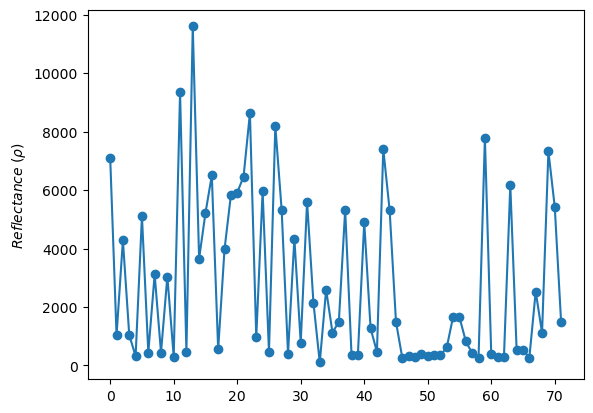

In [30]:
# lets plot the entire dataset (use the ':' symbol for all values) for pixel [0,0]
# this is refered to as a timeseries
plt.plot(lyr_stack[:,0,0],marker='o')
plt.ylabel(r"$Reflectance\ (\rho)$")

#### Test Your Understanding:
Plot the timeseries for the last pixel in the first column. Also plot the timeseries for the last pixel in the last row

In [31]:
# test your understanding kernel:


# Section 4 - Cloud Masking
As we can see from the above plot, there is allot of variabilty in time with the pixel. The variation is due to clouds, where a cloud crosses the pixel, it has a very bright reflectance value. This means that to get meaningful values out of the Layerstack, we need to set the clouded values to Nan (not-a-number).<br><br>
We will be using a technique similar to the method outlined in this methodology:<br>
Candra, D. S., Phinn, S., & Scarth, P. (2020). Cloud and cloud shadow masking for Sentinel-2 using multitemporal images in global area. International Journal of Remote Sensing, 41(8), 2877-2904.<br><br>

Available here:<br>
https://www.tandfonline.com/doi/full/10.1080/01431161.2019.1697006

In the methodology, the authors talk about using a 'reference image', which is an image that the the user has to manually pick out that is cloud free. This is time consuming and not particully good for operational services, so we will create our own 'reference image' by aggregating the data in time.

numpy has allot of extreamly powerful operations for multidimensional aggregation, including 'np.nanmin'. This function calculates the minimum value of an array in any or all axes. More detail on handling operations and 'nan' values please refer to this:
https://realpython.com/numpy-max-maximum/

Minimum Value in the first pixel:  102.0


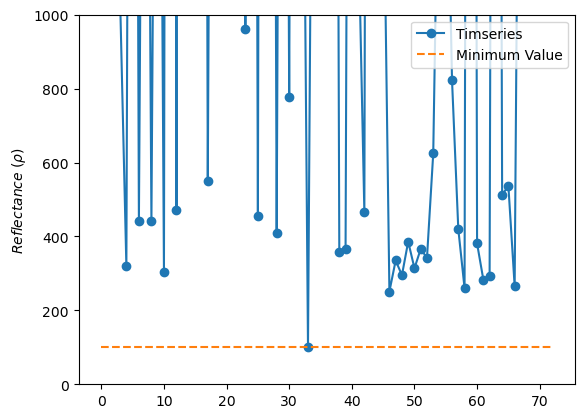

In [32]:
# we can test this by finding the absolutely lowest pixel value in the the first
# pixel
first_pixel = lyr_stack[:,0,0]
min_val = np.nanmin(first_pixel)
print ('Minimum Value in the first pixel: ',min_val)

# lets display this value, notice that the orange lines intersects with the 
# minimum values visible in the timeseries.
plt.plot(first_pixel, label='Timseries', marker='o')
plt.plot([0,len(first_pixel)],[min_val,min_val],
         label='Minimum Value',ls='--')
plt.ylim(0,1000)
plt.ylabel(r"$Reflectance\ (\rho)$")
plt.legend()

This is more powerful when we can find the minimum value for all pixels in the Layerstack by telling 'np.nanmin' which axis we 
want it to operate on. Time is the first axis, so we do the operation with:

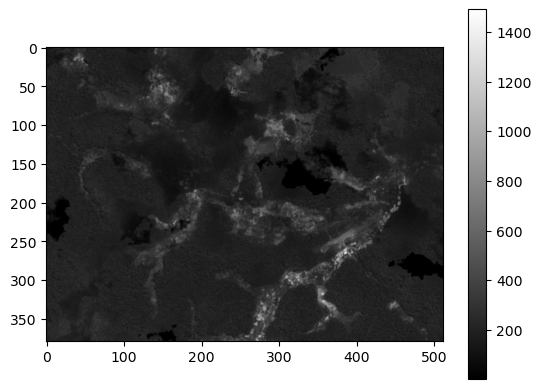

In [33]:
min_of_pixels = np.nanmin(lyr_stack, axis=0)

# min_of_pixels is called a 'composite' as it is an aggregation
# accross an axis. We can display this composite as an image
plt.imshow(min_of_pixels)
plt.colorbar()

# the landcovers, like sand and soil, will have higher minimum values
# than that of landcovers like vegetation and forest.

In [34]:
# we can also see that min_of_pixels corresponds with the minimum value
# we found from the first pixel
min_val == min_of_pixels[0,0]

True

In [35]:
# make a quick copy of lyr_stack, so we dont have to compile it again 
# if something goes wrong. We will mask the clouds in this copy
cloud_masked_lyr_stack = np.copy(lyr_stack)

In the cloud masking methodology, a cloud is declared if a blue pixel value is more than 1000 above the reference. In our case, a pixel is clouded if the values is more than 1000 than min_of_pixels.

In [36]:
# We can implement this by subtracting min_of_pixels from lyr_stack
dif_from_ref = lyr_stack - min_of_pixels

# set the threshold
critical_cloud_threshold = 1000

# create a variable to designate which pixels are clouded
are_clouded = dif_from_ref > critical_cloud_threshold

# now we set the values in this array that are above 1000 as np.nan
# in lyr_stack, which are the clouds
cloud_masked_lyr_stack[are_clouded] = np.nan

# for the first pixel, examine the first 10 values and see which are masked
print ('Reflectance Values:')
print (lyr_stack[:10,0,0])

print ('Clouded:')
print (are_clouded[:10,0,0]) 
# True means the value is clouded. Notice that the pixels that are clouded
# have very high reflectance.

Reflectance Values:
[7108. 1036. 4284. 1042.  320. 5104.  442. 3116.  442. 3044.]
Clouded:
[ True False  True False False  True False  True False  True]


Text(0, 0.5, '$Reflectance\\ (\\rho)$')

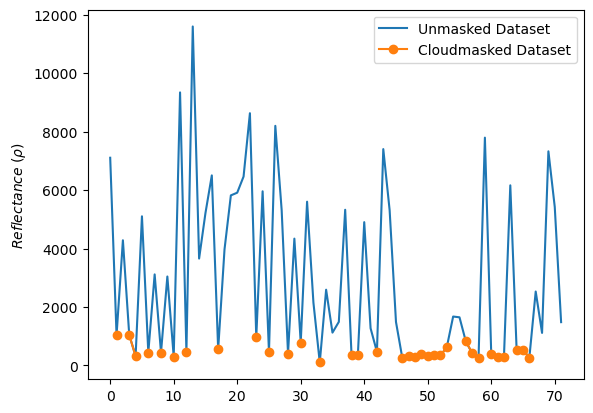

In [37]:
# lets see if this has worked by looking at the first pixel timeseries
plt.plot(lyr_stack[:,0,0],label='Unmasked Dataset')
plt.plot(cloud_masked_lyr_stack[:,0,0],marker='o',label='Cloudmasked Dataset')
plt.legend()
plt.ylabel(r"$Reflectance\ (\rho)$")

# the remaining values are the points displayed in orange. 

Now the data has the clouds have been masked, we can create a composite of the cloud masked dataset by averaging accross time, much like we did when creating the minimum reference in the cloud masking

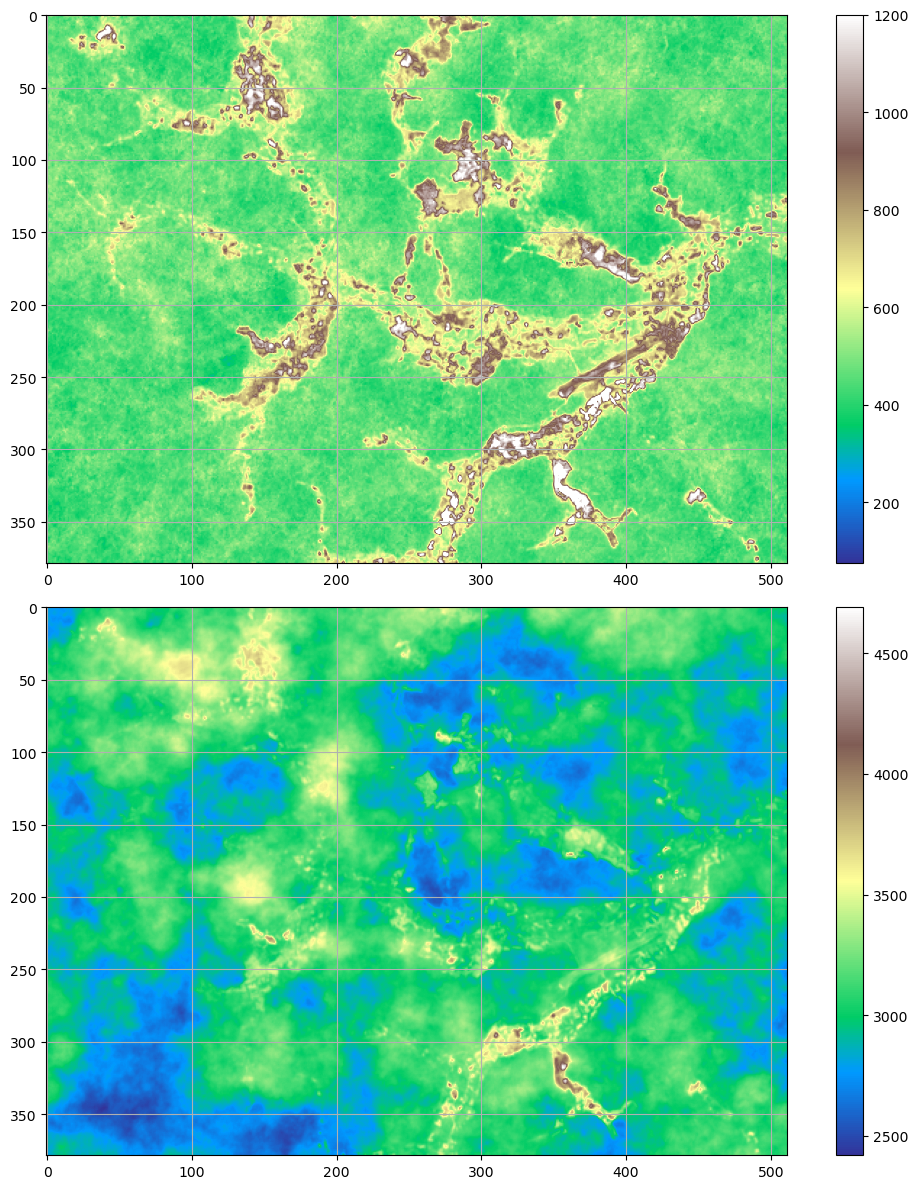

In [70]:
# the synatx is the same between 'np.nanmin' and 'np.nanmean', where the
# first argument is the 3d array to perform the operation on, and we 
# specificy the axis (in this case it is 0)
cloud_masked_average_composite = np.nanmean(cloud_masked_lyr_stack, axis = 0)

# we will compare the compositie from the cloud masked dataset and the 
# composite from the raw lyr_stack
raw_composite = np.nanmean(lyr_stack,axis=0)

# plot the composites - where you can see that the cloud masking has
# has removed the cloud signal and we can clearly see the pattern of
# landcover. 

# We will also display the the data with a colormap so we can see the
# spatial patterns better. The green values represent pixels with 
# generally low blue reflectance, like vegetation. The white/brown
# values are bright regions of exposed soil or water.

fig,axs = plt.subplots(2,1,figsize=(10,12))
im = axs[0].imshow(cloud_masked_average_composite,
                   vmax=1200,vmin=75, cmap='terrain')
plt.colorbar(im, ax=axs[0])

im = axs[1].imshow(raw_composite,cmap='terrain')
plt.colorbar(im, ax=axs[1])

[i.grid() for i in axs]
plt.tight_layout()

In [39]:
# There are many methods of performing cloud masking. A very good example that uses a
# machine learning classifier to find the likihood a pixel is clouded can be found here:
# https://github.com/sentinel-hub/sentinel2-cloud-detector

#### Test Your Understanding:
What is the effect of changing the critical_cloud_threshold parameter on the composites?

In [40]:
# test you understanding kernel:


# Section 5 - Generating NDVI
Using the above techniques, we can generate NDVI data from the Red band (B4) and NIR (B8). This can be used to look at the change in NDVI over the year, or create composites of NDVI

In [41]:
# the following code opens up the reflectance data needed for NDVI and 
# stores the data as 3D arrays in the dictionary

ndvi_bands = ['B4', 'B8']

# create a doctionary where to put the data
reflectance_dict = {}

# loop throguh the bands to open them
for band in ndvi_bands:
    
    # build the file path to the data repository
    file_repository = os.path.join(file_root,band,'aoi')
    
    # use 'glob' to list all the files in the repository
    # glob uses 'wildcards' (*), where the (*) symbol is used to 
    # list all files matching that pattern
    # '*tif lists all the files with a 'tif suffix'
    # '*abc*' lists all files with 'abc' inside
    list_of_files = glob.glob(file_repository+'/*')
    
    # glob randomizes the result, so sort them which will 
    # put them into chronological order
    sorted_file_list = sorted(list_of_files)
    
    arrays_to_concatenate = []
    
    # loop throguh each of the files that fit the description
    for file in sorted_file_list:
        
        # find if the filename has the year of interest inside
        if year not in file:
            # if it does not, skip it and dont open it
            continue
            
        opn = gdal.Open(file)
        arr = opn.ReadAsArray()
        arrays_to_concatenate.append(arr)
        
    # concatenate all the monthly datasets
    loop_lyr_stack = np.concatenate(arrays_to_concatenate, axis = 0)
        
    # use the cloud mask array to mask this Layerstack
    loop_lyr_stack[are_clouded] = np.nan
    reflectance_dict[band] = loop_lyr_stack
    
print ('B4 Data Shape: ', reflectance_dict['B4'].shape)
print ('B8 Data Shape: ', reflectance_dict['B8'].shape)

B4 Data Shape:  (72, 379, 512)
B8 Data Shape:  (72, 379, 512)


In [42]:
# using the information for the NDVI equation in this resourse:
# https://www.indexdatabase.de/db/i-single.php?id=58
# we can see the formulae for NDVI is 
# (B8 - B4) - (B8 + B4)

# we can implement this to create a 3d Dataset of NDVI
ndvi = (reflectance_dict['B8'] - reflectance_dict['B4']) / (reflectance_dict['B8'] + reflectance_dict['B4'])

Lets have alook at the values contained in the NDVI cube we can see the majority of values are over 0.6, which is expected as this region is in the rainforest. The lower values are landcovers like exposed soil or water

Text(0.5, 0, 'NDVI')

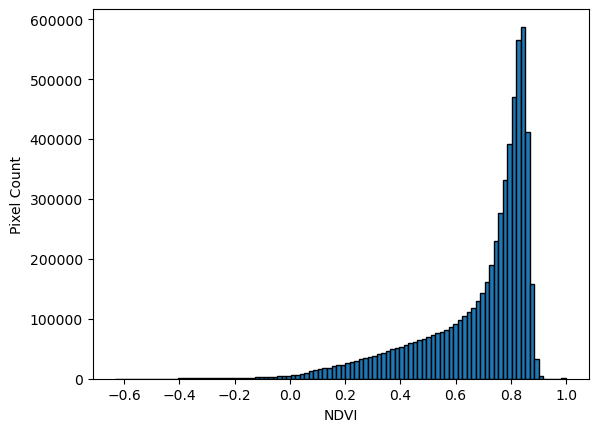

In [44]:
_ = plt.hist(ndvi.flatten(), bins = 100, edgecolor='k')
plt.ylabel('Pixel Count')
plt.xlabel('NDVI')

We can see where pixels have undergone deforestation when there are sharp drops in NDVI. An example of this is the pixel at [349,395], where the NDVI drops from ~0.75 to ~-0.2, which indicates a severe change from vegetation to bare soil.

Text(0.5, 0, '$Timestep$')

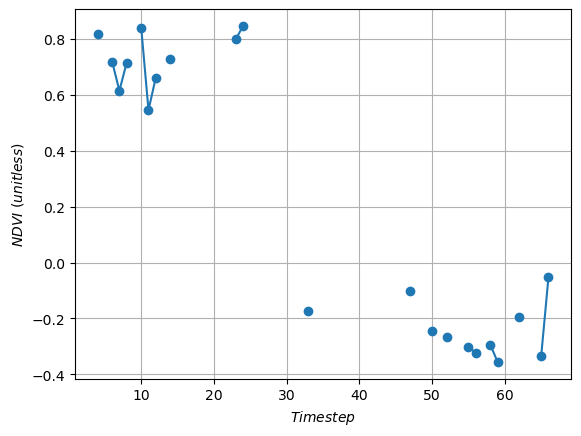

In [45]:
plt.plot(ndvi[:,349,395],marker='o')
plt.grid()
plt.ylabel('$NDVI\ (unitless)$')
plt.xlabel('$Timestep$')

we can also create a composite of NDVI so we can see the typical vegetation response spatially. We can do this just like when 
calcualting the reference minimum, but by using the 'np.nanmean'operation instead.

In [46]:
ndvi_composite = np.nanmean(ndvi, axis=0)

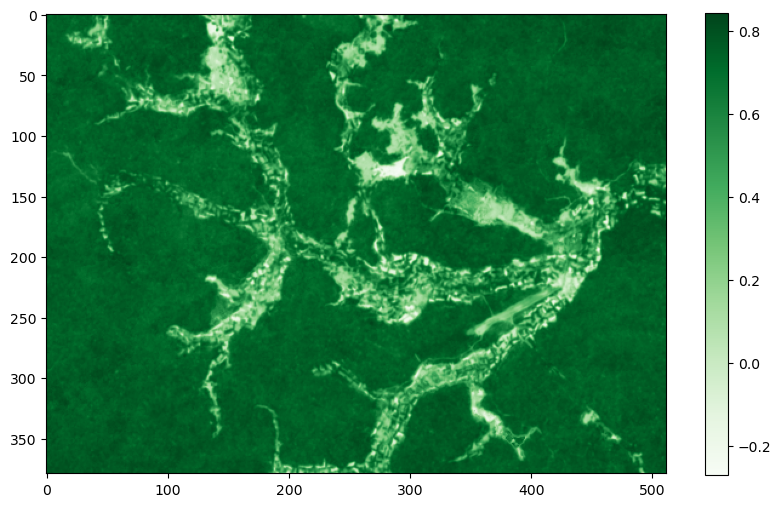

In [47]:
# you can see all the regions of mining and regions where the forest
# has been deforested where there are low values.
plt.figure(figsize=(10,6))
plt.imshow(ndvi_composite,cmap='Greens')
plt.colorbar()

#### Test Your Understanding:
Using the following link, calculate a new spectral index case 'Soil Adjusted Vegetation Index' (SAVI):<br>
https://www.indexdatabase.de/db/i-single.php?id=87

In [48]:
# Test your Understanding kernel:


## Section 6 - RGB True Color Image
Now that we know how to mask out the clouds, we are going to loop throguh the bands, load all the data for each one and mask 
the clouds. This creatse multiple cloud masked arrays which we can create an RGB true color from the annual average composites.<br><br> For more information on creating true color images and false color composities, please use the following: <br> https://coolum001.github.io/landsat8.html

In [49]:
# create a doctionary where to put the data
reflectance_dict = {}

# loop throguh the bands to open them
for band in bands:
    
    # build the file path to the data repository
    file_repository = os.path.join(file_root,band,'aoi')
    
    # use 'glob' to list all the files in the repository
    # glob uses 'wildcards' (*), where the (*) symbol is used to 
    # list all files matching that pattern
    # '*tif lists all the files with a 'tif suffix'
    # '*abc*' lists all files with 'abc' inside
    list_of_files = glob.glob(file_repository+'/*')
    
    # glob randomizes the result, so sort them which will 
    # put them into chronological order
    sorted_file_list = sorted(list_of_files)
    
    arrays_to_concatenate = []
    
    # loop throguh each of the files that fit the description
    for file in sorted_file_list:
        
        # find if the filename has the year of interest inside
        if year not in file:
            # if it does not, skip it and dont open it
            continue
            
        opn = gdal.Open(file)
        arr = opn.ReadAsArray()
        arrays_to_concatenate.append(arr)
        
    # concatenate all the monthly datasets
    loop_lyr_stack = np.concatenate(arrays_to_concatenate, axis = 0)
        
    # use the cloud mask array to mask this Layerstack
    loop_lyr_stack[are_clouded] = np.nan
    reflectance_dict[band] = loop_lyr_stack
    

We now have a dictionary with all the band data in each directory, so we can create composites of each band.

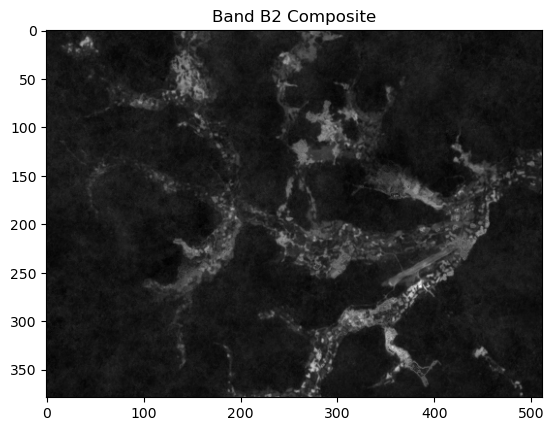

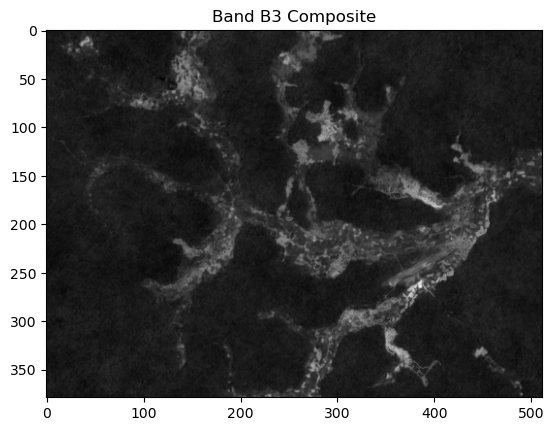

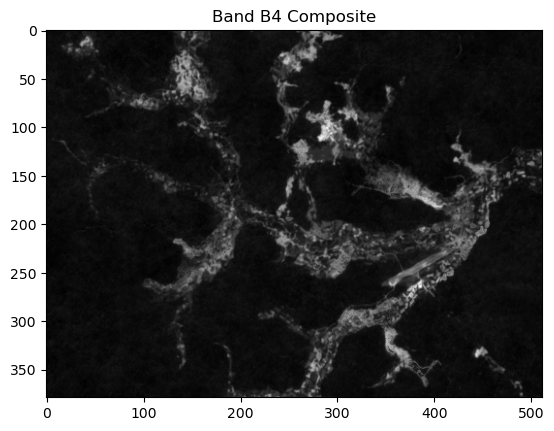

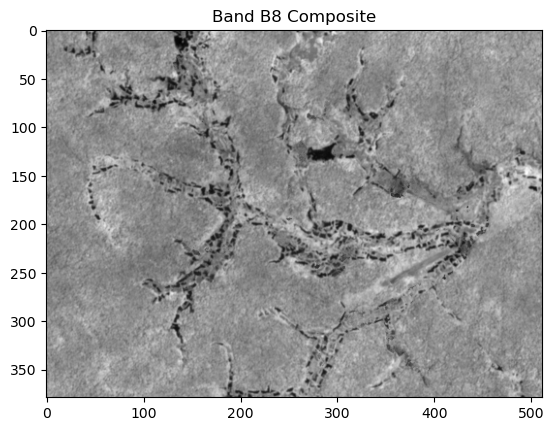

In [50]:
composites = {}

for band in reflectance_dict:
    
    comp = np.nanmean(reflectance_dict[band], axis=0)
    composites[band] = comp
    
    plt.figure()
    plt.imshow(comp)
    plt.title('Band %s Composite'%band)

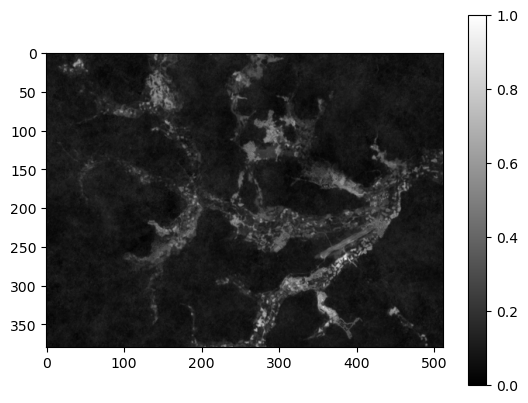

In [51]:
# to create an RGB true color, we need to normlize the values, given the maximum 
# and minimum values in the array. We can use the following function to do this

def normalize(in_arr, min_val = None, max_val = None, cap = False):
 
    if min_val is None:
        min_val = np.nanmin(in_arr)
    if max_val is None:
        max_val = np.nanmax(in_arr)
    ret = (in_arr - min_val) / (max_val - min_val)
    if cap == True:
        ret[ret<0] = 0
        ret[ret>1] = 1
    return ret

# we can see the values are now between 0 and 1
plt.imshow(normalize(composites['B2']))
plt.colorbar()

To create an RGB, we normalize the composites and stcak them up in the format the Matplotlib can use. Values need to be 
multiplied by 255 so the image can be generated. 'max_val' denotes the upper threshold which values will be capped at
change this values for different effects.

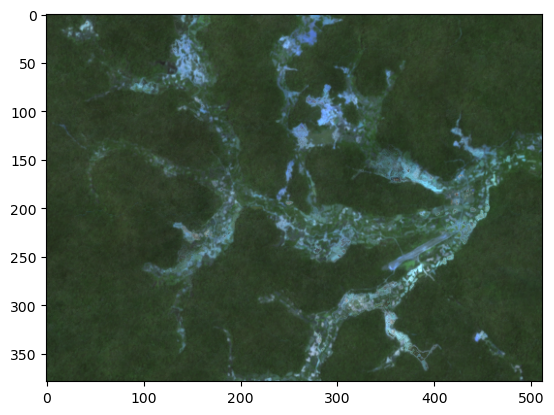

In [52]:
max_val = 2500
rgb_list = [normalize(composites[band], cap=True, 
                      max_val=max_val, min_val = 0)*255 
            for band in ['B2','B3','B4']]

rgb_array = np.dstack(rgb_list).astype(np.uint8)
im = Image.fromarray(rgb_array)
plt.imshow(im)